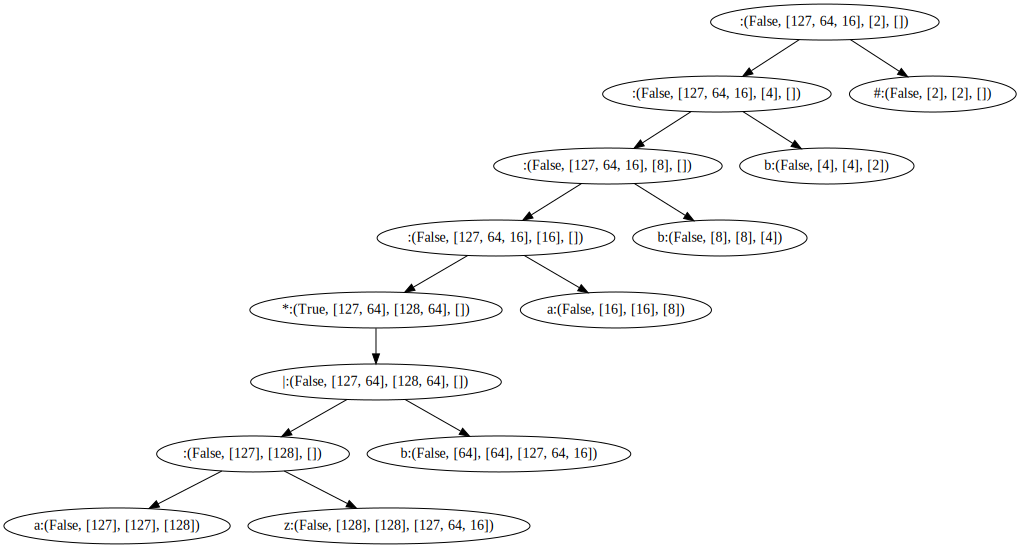

In [136]:
regK = "(az|b)*abb#"

from graphviz import Digraph


class Node:
    def __init__(self, v = None, l = None, r = None):
        self.left = l
        self.right = r
        self.value = v
        self.followpos = []
        self.label_i = ''
    def copy(cur):
        return Node(cur.value, cur.left, cur.right)
    left = None
    right = None
    value = None

    def show_tree(pt, dot = None, show_params=False):
        if not dot:
            dot = Digraph()
        label = pt.value + ":" + str(pt.label_i) 
        def nodes_to_i(nodes):
            return [node.i for node in nodes]
        if show_params:
            label = label + "(" + str(pt.nullable) + ", " +  str(nodes_to_i(pt.firstpos))+ ", " +  str(nodes_to_i(pt.lastpos))+ ", " +  str(nodes_to_i(pt.followpos))+ ")" 
        dot.node(str(pt.i), label)
        if pt.left:
            dot.edge(str(pt.i), str(pt.left.i))
            pt.left.show_tree(dot, show_params=show_params)
        if pt.right:
            dot.edge(str(pt.i), str(pt.right.i))
            pt.right.show_tree(dot, show_params=show_params)
        return dot
    def count_i(self, i = 0):
        self.i = i
        if self.left:
            self.left.count_i(i*2+1)
        if self.right:
            self.right.count_i(i*2+2)

    def count_nullable(self):
        if self.left:
            self.left.count_nullable()
        if self.right:
            self.right.count_nullable()

        if self.value == '*':
            self.nullable = True
        elif self.value== '|':
            self.nullable = self.left.nullable or self.right.nullable
        else:
            self.nullable = False
        return self.nullable
    def count_firstpos(self):
        if self.left:
            self.left.count_firstpos()
        if self.right:
            self.right.count_firstpos()

        if self.value in ['*', '+']:
            self.firstpos = self.left.firstpos.copy()
        elif self.value == '':
            self.firstpos = self.left.firstpos.copy()
            if self.left.nullable:
                self.firstpos += self.right.firstpos
        elif self.value== '|':
            self.firstpos = self.left.firstpos + self.right.firstpos 
        else:
            self.firstpos = [self]
        return self.firstpos
    def count_lastpos(self):
        if self.left:
            self.left.count_lastpos()
        if self.right:
            self.right.count_lastpos()

        if self.value in ['*', '+']:
            self.lastpos = self.left.lastpos.copy()
        elif self.value == '':
            self.lastpos = self.right.lastpos.copy()
            if self.right.nullable:
                self.lastpos += self.left.lastpos
        elif self.value== '|':
            self.lastpos = self.left.lastpos + self.right.lastpos 
        else:
            self.lastpos = [self]
        return self.lastpos
    
    def count_followpos(self):
        if self.left:
            self.left.count_followpos()
        if self.right:
            self.right.count_followpos()
        if self.value == '':
            for i in self.left.lastpos:
                i.followpos += self.right.firstpos
        elif self.value == '*':
            for i in self.lastpos:
                i.followpos += self.firstpos

    def foreach_deep(self, funcIn = None, FuncOut = None):
        if funcIn:
            funcIn(self)
        if self.left:
            self.left.foreach_deep(funcIn, FuncOut)
        if self.right:
            self.right.foreach_deep(funcIn, FuncOut)
        if FuncOut:
            FuncOut(self)
        

def buildParseTree(expr):
    tree = Node()
    stack = [tree]

    def CAT(cur, i):
        if not cur.value is None:
            cur.left = cur.copy()
            cur.right = Node(i)
            cur.value = ''
            cur = cur
        else:
            cur.value = i    
        return cur
    cur = tree
    for i in expr:
        if i == '|':
            cur.left = cur.copy()
            cur.right = Node()
            cur.value = '|'
            
            cur = cur.right
        elif i in ['*', '+']:
            cur.left = cur.copy()
            cur.right = None
            cur.value = i
        elif i == '(':
            cur = CAT(cur, None)
            stack.append(cur)
        elif i == ')':
            cur = stack.pop()
        else:
            cur = CAT(cur,i)
    return tree


pt = buildParseTree(regK)
pt.count_i()
pt.count_nullable()
pt.count_firstpos()
pt.count_lastpos()

pt.count_followpos()


pt.show_tree(show_params=True)






1 [2]
2 [1, 3, 4]
3 [1, 3, 4]
4 [5]
5 [6]
6 [7]
7 []
['a', '#', 'b', 'z']


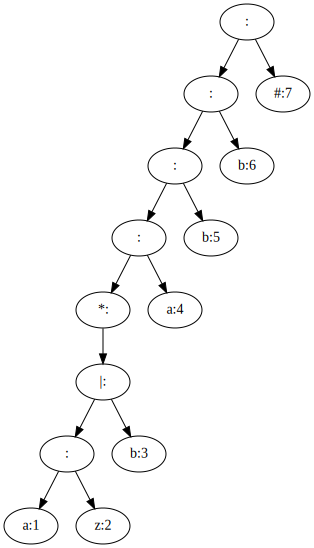

In [137]:
# Print folowpos in table

nodes = []
def make_nodes(node):
    if node.value not in ('+', '|', '', '*'):
        nodes.append(node)

pt.foreach_deep(FuncOut=make_nodes)

for i, node in enumerate(nodes, 1):
    node.label_i = i

    
 
for node in nodes:
    print(node.label_i, [n.label_i for n in node.followpos])

symbols = list(set([node.value for node in nodes]))
print(symbols)
pt.show_tree(show_params=False)

In [129]:
def make_ka(root: Node, symbols, end_symb='#'):
    def make_state(nodes):
        return tuple(sorted([node.label_i for node in nodes]))
    
    def is_end(nodes):
        for node in nodes:
            if node.value == end_symb:
                return True
        return False
    Dstates = []
    
    table = {}
    queue = [root.firstpos]

    last = []
    while len(queue):
        state = queue.pop()
        Dstates += [make_state(state)]

        for c in symbols:
            U = []
            for p in state:
                if p.value == c:
                    U += p.followpos
            U = list(set(U))
            if not len(U): 
                continue
            
            if make_state(U) not in Dstates:
                queue.append(U)

           

            table[make_state(state), c] = [make_state(U)]

            print(make_state(state), c, [make_state(U)])

        if is_end(state):
                last += [make_state(state)]
    
    return [Dstates[0]], last, table    






In [118]:
def fix_names(first, last, table):
    names = []

    for f,v in table:
        if f not in names:
            names += [f]
        for t in table[f,v]:
            if not t in names:
                names += [t]
    newTable = {}
    for f,v in table:
        newTable[(names.index(f), v)]  = [names.index(t) for t in table[f,v]]
    return [names.index(t) for t in first], [names.index(t) for t in last], newTable


In [119]:
def print_ka(first, end, Dtran):
    g = Digraph()

    g.node('S', 'Start')
    g.node('E', 'End')

    for i in first:
        g.edge('S', str(i))
    
    for i in end:
        g.edge(str(i), 'E')
        

    for f,v in Dtran:
        for t in Dtran[(f,v)]:
            g.node(str(f))
            g.node(str(t))
            g.edge(str(f), str(t), v )

    return g


(1, 2, 3) a [(1, 2, 3, 4)]
(1, 2, 3) b [(1, 2, 3)]
(1, 2, 3, 4) a [(1, 2, 3, 4)]
(1, 2, 3, 4) b [(1, 2, 3, 5)]
(1, 2, 3, 5) a [(1, 2, 3, 4)]
(1, 2, 3, 5) b [(1, 2, 3, 6)]
(1, 2, 3, 6) a [(1, 2, 3, 4)]
(1, 2, 3, 6) b [(1, 2, 3)]


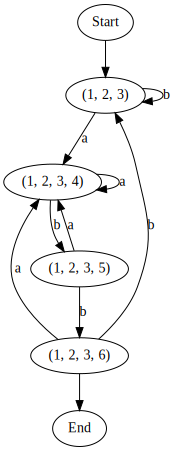

In [132]:
print_ka(*make_ka(pt, symbols))

In [61]:
def reverseKa(first, last, Dtran):
    newDtran = {}
    for f,v in Dtran:
        for t in Dtran[(f,v)]:
            if (t,v) not in newDtran:
                newDtran[(t, v)] = []     
            newDtran[(t, v)] += [f]
    return last, first, newDtran

(1, 2, 3) a [(1, 2, 3, 4)]
(1, 2, 3) b [(1, 2, 3)]
(1, 2, 3, 4) a [(1, 2, 3, 4)]
(1, 2, 3, 4) b [(1, 2, 3, 5)]
(1, 2, 3, 5) a [(1, 2, 3, 4)]
(1, 2, 3, 5) b [(1, 2, 3, 6)]
(1, 2, 3, 6) a [(1, 2, 3, 4)]
(1, 2, 3, 6) b [(1, 2, 3)]


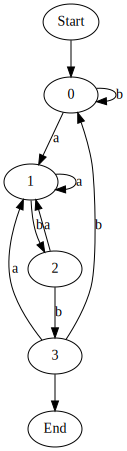

In [133]:
def toDFA(first, last, table):
    """
    Алгоритм Томпсона строит по НКА эквивалентный ДКА следующим образом:

    Начало.
    Шаг 1. Помещаем в очередь Q
        множество, состоящее только из стартовой вершины.
    Шаг 2. Затем, пока очередь не пуста выполняем следующие действия:
        Достаем из очереди множество, назовем его q
        Для всех c∈Σ
        посмотрим в какое состояние ведет переход по символу c из каждого состояния в q. Полученное множество состояний положим в очередь Q
        только если оно не лежало там раньше. Каждое такое множество в итоговом ДКА будет отдельной вершиной, в которую будут вести переходы по соответствующим символам.
        Если в множестве q

        хотя бы одна из вершин была терминальной в НКА, то соответствующая данному множеству вершина в ДКА также будет терминальной.

    Конец.
    """
    def nodes_to_state_name(l):
        return tuple(set(l))

    symbols = []
    for _, v in table:
        symbols += [v]
    symbols = list(set(symbols))

    queue = [first.copy()]

    newTable = {}
    states = []

    while len(queue):
        nodes = queue.pop()
        states.append(nodes_to_state_name(nodes))
        for c in symbols:
            state = []
            for node in nodes:
                if (node, c) in table:
                    state += table[(node,c)]
            state = nodes_to_state_name(state)

            if not len(state):
                continue
            newTable[(nodes_to_state_name(nodes), c)] = [state]
            
            if state not in states:
                queue.append(state)
            
       
    def intersection(lst1, lst2):
        lst3 = [value for value in lst1 if value in lst2]
        return lst3


    return [nodes_to_state_name(first)], [
        state for state in states if intersection(state, last)
    ], newTable



modified = fix_names(*toDFA(*reverseKa(*fix_names(*toDFA(*reverseKa(*make_ka(pt, symbols)))))))

print_ka(*modified)




In [71]:
import inspect
lines = inspect.getsource(make_nodes)
print(lines)

def make_nodes(node):
    if node.value not in ('+', '|', '', '*'):
        nodes.append(node)



In [135]:
st = "aabb"

def check_ka(st, fir, las, table):
    state = fir[0]
    for c in st:
        print(state, c)
        if (state, c) not in table:
            return False
        state = table[(state,c)][0]

    return state in las

check_ka(st, *modified)


0 a
1 a
1 b
2 b


True